In [51]:

import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
import math as mt 
import scipy.special as sci
from matplotlib.animation import FuncAnimation
import tqdm as tqdm


In [52]:
#PARA CORRER EL CODIGO HAY QUE INSTALAR LAS SIGUEINTES LIBRERIAS


#Install opencv-python (which is the official pre-built OpenCV package for Python) by issuing the following command:

#pip install opencv-python

#pip install screeninfo




# Función para generar modos de haces gaussianos:

$$
\mathbf{E}(r, z) = E_0 \, \hat{x} \, \frac{w_0}{w(z)} 
\exp\left( -\frac{r^2}{w^2(z)} \right)
\exp\left( -i \left( k z + \frac{k r^2}{2R(z)} - \psi(z) \right) \right)
$$

### Donde:
- $r$ es la distancia radial desde el eje central del haz,  
- $z$ es la distancia axial desde el foco del haz (o "waist"),  
- $i$ es la unidad imaginaria,  
- $k = \frac{2\pi n}{\lambda}$ es el número de onda (en radianes por metro) para una longitud de onda en espacio libre $\lambda$, y $n$ es el índice de refracción del medio en el que el haz se propaga,  
- $E_0 = E(0,0)$ es la amplitud del campo eléctrico en el origen $(r=0, z=0)$,  
- $w(z)$ es el radio en el cual la amplitud del campo cae a $1/e$ de su valor axial (es decir, donde la intensidad cae a $1/e^2$ de su valor axial), en el plano $z$ a lo largo del haz,  
- $w_0 = w(0)$ es el radio de la cintura (waist),  
- $R(z)$ es el radio de curvatura de los frentes de onda del haz en $z$, y  
- $\psi(z) = \arctan(z/z_R)$ es la fase de Gouy en $z$, un término de fase extra más allá del atribuido a la velocidad de fase de la luz.  



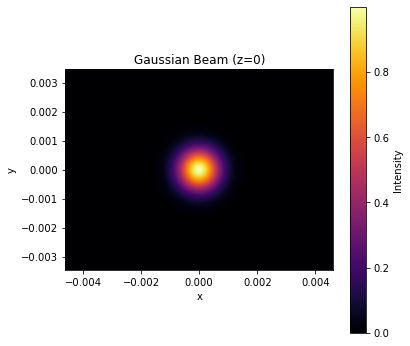

In [53]:

Nxpix = 1024 ## DIMENSIONES DEL SLM
Nypix = 768
Pix_size=9e-6 #TAMANO DEL PIXEL ES 9um

##GENERACION DE BEAMS GAUSSIANOS

def gaussian_beam(r, z, w0, k):
    """
    Computes the Gaussian beam profile based on the given equation.
    
    Parameters:
        r  : Radial coordinate
        z  : Axial coordinate (propagation distance)
        w0 : Beam waist (radius at focus)
        k  : Wave number
    
    Returns:
        Complex field amplitude of the Gaussian beam.
    """
    z_R = np.pi * w0**2 / k  # Rayleigh range
    w_z = w0 * np.sqrt(1 + (z / z_R) ** 2)  # Beam waist at z
    R_z = z * (1 + (z_R / z) ** 2) if z != 0 else np.inf  # Radius of curvature
    psi_z = np.arctan(z / z_R)  # Gouy phase
    
    amplitude = (w0 / w_z) * np.exp(-r**2 / w_z**2)
    phase = np.exp(-1j * (k * z + k * r**2 / (2 * R_z) - psi_z))
    
    return amplitude * phase

# Define grid
N = (Nxpix,Nypix)  # Grid size
x = np.linspace(-Nxpix/2*Pix_size, Nxpix/2*Pix_size, Nxpix)
y = np.linspace(-Nypix/2*Pix_size, Nypix/2*Pix_size, Nypix)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)


# Set Gaussian beam parameters
w0 = 1000* 10**-6  # Beam waist
z = 0  # Propagation distance
k = 2*np.pi/633e-9  # Wave number

# Compute beam intensity
gaussian_mode = gaussian_beam(R, z, w0, k)
intensity = np.abs(gaussian_mode) ** 2

# Plot the intensity pattern
plt.figure(figsize=(6, 6))
plt.imshow(intensity, extent=[-Nxpix/2*Pix_size, Nxpix/2*Pix_size, -Nypix/2*Pix_size, Nypix/2*Pix_size], cmap='inferno')
plt.colorbar(label='Intensity')
plt.title(f'Gaussian Beam (z={z})')
plt.xlabel('x')
plt.ylabel('y')
plt.show()




# Función de modos Laguerre-Gaussianos:

$$
u(r, \phi, z) = C_{lp}^{LG} \frac{1}{w(z)}
\left( \frac{r\sqrt{2}}{w(z)} \right)^{|l|}
\exp\left( -\frac{r^2}{w^2(z)} \right)
L_p^{|l|} \left( \frac{2r^2}{w^2(z)} \right) \times
$$

$$
\exp\left(-ik \frac{r^2}{2R(z)}\right)
\exp(-i l \phi) \exp(i \psi(z)),
$$

donde $L_p^{l}$ son los **polinomios de Laguerre generalizados**.  
$C_{lp}^{LG}$ es la constante de normalización requerida:

$$
C_{lp}^{LG} = \sqrt{\frac{2p!}{\pi (p + |l|)!}}
\quad \Rightarrow \quad
\int_0^{2\pi} d\phi \int_0^{\infty} dr \, r \, |u(r,\phi,z)|^2 = 1.
$$


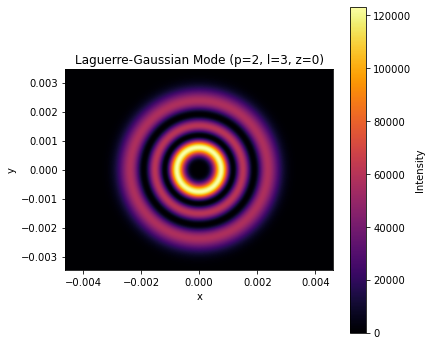

In [54]:

##GENERAR MODOS LAGUERRE GAUSS

from scipy.special import genlaguerre

def laguerre_gauss_mode(p, l, r, phi, z, w0, k):
    """
    Computes the Laguerre-Gaussian mode of light.
    
    Parameters:
        p  : Radial index (non-negative integer)
        l  : Azimuthal index (integer)
        r  : Radial coordinate
        phi: Azimuthal coordinate
        z  : Propagation distance
        w0 : Beam waist
        k  : Wave number
    
    Returns:
        Complex field amplitude of the LG mode.
    """
    z_R = np.pi * w0**2 / k  # Rayleigh range
    w_z = w0 * np.sqrt(1 + (z / z_R) ** 2)  # Beam waist at z
    R_z = z * (1 + (z_R / z) ** 2) if z != 0 else np.inf  # Radius of curvature
    psi_z = np.arctan(z / z_R)  # Gouy phase
    
    C_lp = np.sqrt(2 * np.math.factorial(p) / (np.pi * np.math.factorial(p + abs(l))))
    R = np.sqrt(2) * r / w_z
    L = genlaguerre(p, abs(l))(2 * r**2 / w_z**2)  # Generalized Laguerre polynomial
    
    amplitude = C_lp * (R**abs(l)) * np.exp(-r**2 / w_z**2) * L
    phase = np.exp(-1j * k * r**2 / (2 * R_z)) * np.exp(-1j * l * phi) * np.exp(1j * psi_z)
    
    return (1 / w_z) * amplitude * phase

# Define grid
N = (Nxpix,Nypix)  # Grid size
x = np.linspace(-Nxpix/2*Pix_size, Nxpix/2*Pix_size, Nxpix)
y = np.linspace(-Nypix/2*Pix_size, Nypix/2*Pix_size, Nypix)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
Phi = np.arctan2(Y, X)


# Set LG mode indices and parameters
p, l = 2, 3 # Example mode numbers
w0 = 1000* 10**-6  # Beam waist
z = 0  # Propagation distance
k = 2*np.pi/633e-9  # Wave number

# Compute mode intensity
LG_mode = laguerre_gauss_mode(p, l, R, Phi, z, w0, k)
intensity = np.abs(LG_mode) ** 2

# Plot the intensity pattern
plt.figure(figsize=(6, 6))
plt.imshow(intensity, extent=[-Nxpix/2*Pix_size, Nxpix/2*Pix_size, -Nypix/2*Pix_size, Nypix/2*Pix_size], cmap='inferno')
plt.colorbar(label='Intensity')
plt.title(f'Laguerre-Gaussian Mode (p={p}, l={l}, z={z})')
plt.xlabel('x')
plt.ylabel('y')

plt.savefig(f'FIGURAS\LG_p={p}_l={l}_z={z})')
plt.show()

# Función de modos Hermite-Gaussianos:

$$
E_{nm}(x, y, z) = E_0 \frac{w_0}{w(z)}
\cdot H_n \left( \sqrt{2} \frac{x}{w(z)} \right) 
\exp\left( -\frac{x^2}{w^2(z)} \right)
\cdot H_m \left( \sqrt{2} \frac{y}{w(z)} \right) 
\exp\left( -\frac{y^2}{w^2(z)} \right)
$$

$$
\cdot \exp \left( -i \left[ k z - (1 + n + m) \arctan \frac{z}{z_R} 
+ \frac{k(x^2 + y^2)}{2R(z)} \right] \right)
$$


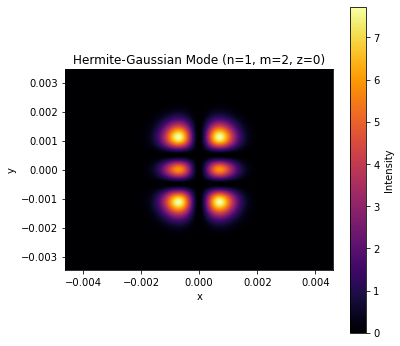

In [55]:


from scipy.special import hermite

def hermite_gauss_mode(n, m, x, y, z, w0, k):
    """
    Computes the Hermite-Gaussian mode of light.
    
    Parameters:
        n  : Mode index along x
        m  : Mode index along y
        x  : x-coordinate
        y  : y-coordinate
        z  : Propagation distance
        w0 : Beam waist
        k  : Wave number
    
    Returns:
        Complex field amplitude of the HG mode.
    """
    z_R = np.pi * w0**2 / k  # Rayleigh range
    w_z = w0 * np.sqrt(1 + (z / z_R) ** 2)  # Beam waist at z
    R_z = z * (1 + (z_R / z) ** 2) if z != 0 else np.inf  # Radius of curvature
    psi_z = (1 + n + m) * np.arctan(z / z_R)  # Gouy phase
    
    X_scaled = np.sqrt(2) * x / w_z
    Y_scaled = np.sqrt(2) * y / w_z
    H_n = hermite(n)(X_scaled)
    H_m = hermite(m)(Y_scaled)
    
    amplitude = (w0 / w_z) * H_n * np.exp(-x**2 / w_z**2) * H_m * np.exp(-y**2 / w_z**2)
    phase = np.exp(-1j * (k * z - psi_z + k * (x**2 + y**2) / (2 * R_z)))
    
    return amplitude * phase


# Define grid
N = (Nxpix,Nypix)  # Grid size
x = np.linspace(-Nxpix/2*Pix_size, Nxpix/2*Pix_size, Nxpix)
y = np.linspace(-Nypix/2*Pix_size, Nypix/2*Pix_size, Nypix)
X, Y = np.meshgrid(x, y)

# Set HG mode indices and parameters
n, m = 1, 2  # Example mode numbers
w0 = 1000* 10**-6  # Beam waist
z = 0  # Propagation distance
k = 2*np.pi/633e-9  # Wave number

# Compute mode intensity
HG_mode = hermite_gauss_mode(n, m, X, Y, z, w0, k)
intensity = np.abs(HG_mode) ** 2

# Plot the intensity pattern
plt.figure(figsize=(6, 6))
plt.imshow(intensity, extent=[-Nxpix/2*Pix_size, Nxpix/2*Pix_size, -Nypix/2*Pix_size, Nypix/2*Pix_size], cmap='inferno')

plt.colorbar(label='Intensity')
plt.title(f'Hermite-Gaussian Mode (n={n}, m={m}, z={z})')
plt.xlabel('x')
plt.ylabel('y')

plt.savefig(f'FIGURAS\HG_n={n}_m={m}_z={z})',dpi=300)
plt.show()

##  Este codigo es para importar cualquier imagen, redimensionarla a las dimensiones del SLM, y pasarla a escala escala de grises con valores entre 0 y 255

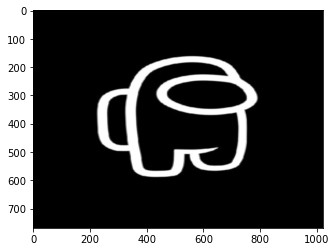

In [56]:
##IMPORTAR IMAGEN/HOLOGRAMA




def resize_image_to_matrix(image_path, width, height):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
    if image is None:
        raise ValueError("Image not found or unable to load.")
    
    # Resize the image
    resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)
    
    # Convert to a NumPy array with values between 0 and 255
    pixel_matrix = np.array(resized_image, dtype=np.uint8)
    
    pixel_matrix= cv2.bitwise_not(pixel_matrix) 
    
    return pixel_matrix


Figure=resize_image_to_matrix("Amongus.jpg",1024,768)


pattern=plt.imshow(Figure,cmap="gray")

# Patrones de solo fase 

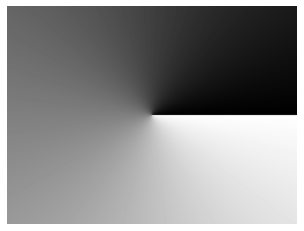

In [57]:
Nxpix = 1024
Nypix = 768
pix_size=9e-6






##GENERACION DE PATRONES AMPLITUD-FASE SEGUN (E.Bolduc,2013) "Exact solution to simultaneous intensity and phase encryption with a single phase-only hologram"

def Amplitude_Phase_pattern(Desired_Field,LAMBDA,NX,NY):
    
    #A=np.absolute(Desired_Field)
    PHI=np.angle(Desired_Field)
    
    
    
    #M=A/np.max(A)
    F=PHI
    
    
    #print(np.shape(M))
    
    psi=np.zeros([NY,NX])
    
 
    
    for n in range(NY):
        for m in range(NX):
            
            
            psi[n,m]=np.mod(F[n,m], 2*np.pi)
         
    
    
    psi_int=((psi - psi.min()) * (1/(psi.max() - psi.min()) * 255)).astype('uint8')
    
    return  psi_int



Output_Field=laguerre_gauss_mode(0, 3, R, Phi, z, 1000e-6, k)+laguerre_gauss_mode(0, -3, R, Phi, z, 1000e-6, k) ##CAMPO ELECTRICO QUE SE QUIERE RECREAR
LG0_1=laguerre_gauss_mode(0, 1, R, Phi, z, 600e-6, k) #MODO GAUSSIANO


Hologram=Amplitude_Phase_pattern(LG0_1,pix_size,Nxpix,Nypix) ##Variable donde guardamos la matrix de pixeles de valores del holograma

pattern=plt.imshow(Hologram,cmap="gray",aspect='equal')
#Field_int=plt.imshow(np.abs(Output_Field)**2,cmap="gray")
plt.axis('off')
plt.savefig("FIGURAS\HologramPhase.jpeg",bbox_inches='tight', transparent="True", pad_inches=0,dpi=300)

## Generar los patrones de amplitud-fase que se enviara al SLM para un campo complejo arbitrario, segun (E.Bolduc,2013) "Exact solution to simultaneous intensity and phase encryption with a single phase-only hologram". El patron se guarda como imagen jpeg (Con estos patrones mirar el orden 1)


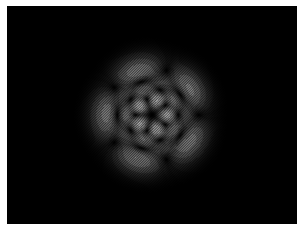

In [58]:

Nxpix = 1024
Nypix = 768
pix_size=9e-6






##GENERACION DE PATRONES AMPLITUD-FASE SEGUN (E.Bolduc,2013) "Exact solution to simultaneous intensity and phase encryption with a single phase-only hologram"


def contrast_function(C, array):
    y = C * (array - 255/2) + 255/2
    return np.clip(y, 0, 255).astype("uint8")


##GENERACION DE PATRONES AMPLITUD-FASE SEGUN (E.Bolduc,2013) "Exact solution to simultaneous intensity and phase encryption with a single phase-only hologram"

def Amplitude_Phase_pattern(Desired_Field, LAMBDA, NX, NY, Contrast=1):
    A = np.abs(Desired_Field)
    PHI = np.angle(Desired_Field)

    M = A / np.max(A)
    F = PHI - np.pi * M

    # Eliminamos los bucles for usando operaciones vectorizadas
    x = np.arange(NX)
    y = np.arange(NY)
    X, Y = np.meshgrid(x, y, indexing='xy')

    psi = M * np.mod(F + (2 * np.pi * X / LAMBDA) + (2 * np.pi * Y / LAMBDA), 2 * np.pi)

    psi_int = ((psi - psi.min()) * (255 / (psi.max() - psi.min()))).astype(np.uint8)

    return contrast_function(Contrast, psi_int)




Output_Field=laguerre_gauss_mode(2, -2, R, Phi, z, 700e-6, k)+laguerre_gauss_mode(1, 3, R, Phi, z, 700e-6, k) ##CAMPO ELECTRICO QUE SE QUIERE RECREAR
LG0_1=laguerre_gauss_mode(0, 4, R, Phi, z, 1000e-6, k) #MODO GAUSSIANOq
HG=hermite_gauss_mode(0, 3, X, Y, z, 1000e-6, k)

Hologram=Amplitude_Phase_pattern(Output_Field,pix_size,Nxpix,Nypix,Contrast=1) ##Variable donde guardamos la matrix de pixeles de valores del holograma

pattern=plt.imshow(Hologram,cmap="gray",aspect='equal')
#Field_int=plt.imshow(np.abs(Output_Field)**2,cmap="gray")
plt.axis('off')
plt.savefig("Figuras\Hologram.pdf",bbox_inches='tight', transparent="True", pad_inches=0,dpi=300)






## Sacar el patron de fase-Amplitud de la transformada de fourier bidimensional de una imagen cargada

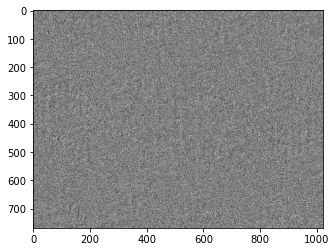

In [59]:
## FFT DE IMAGEN

from scipy.fft import ifftn


import cv2


def resize_image_to_matrix_im(image, width, height):
 
    resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)
    

    
    return resized_image


Figure=resize_image_to_matrix_im(Figure,Nxpix,Nypix)


#FFTHologram=Amplitude_Phase_pattern(ifftn(Figure),pix_size,Nxpix,Nypix)
FFTHologram=resize_image_to_matrix_im(np.angle(ifftn(Figure)),Nxpix,Nypix) #Patron de solo fase


def Fresnel_Grating(f,NX,NY,Pixsize,k): ##Este patron actua como un lente con distancia focal f
    
    psi=np.zeros([NY,NX])
    
    x = np.linspace(-Nxpix/2*Pix_size, Nxpix/2*Pix_size, Nxpix)
    y = np.linspace(-Nypix/2*Pix_size, Nypix/2*Pix_size, Nypix)
    


    
    
    for n in range(NY):
        for m in range(NX):
            
            psi[n,m]=np.mod( (k* (x[m]**2+y[n]**2))/(2*f) , 2*np.pi)
           

                            
    psi_int=((psi - psi.min()) * (1/(psi.max() - psi.min()) * 255)).astype('uint8')
    return psi_int,psi


lens=Fresnel_Grating(450e-3,Nxpix,Nypix,Pix_size,k)[1]

Focused_FFT=FFTHologram

pattern=plt.imshow(Focused_FFT,cmap="gray",aspect='equal')





# Mostrar una imagen en pantalla completa (screen_index=0 es monitor, screen_index=1 es segunda pantalla (SLM))

## Nota: Cerrar la ventana con la tecla "q", es necesario cerrar la ventana antes de volver a correr otra celda de codigo para que el kernel no se muera.

In [10]:


##MOSTRAR IMAGEN EN PANTALLLA
import cv2
import screeninfo

def show_fullscreen_image(image, screen_index=0):
    # Load the image
    #image = cv2.imread(image_path)
    
    # Check if image is loaded successfully
    if image is None:
        print("Error: Unable to load image.")
        return
    
    # Get screen dimensions
    screens = screeninfo.get_monitors()
    if screen_index >= len(screens):
        print("Error: Screen index out of range.")
        return
    
    screen = screens[screen_index]
    screen_width, screen_height = screen.width, screen.height
    
    # Resize the image to fit the screen dimensions
    image = cv2.resize(image, (screen_width, screen_height))
    
    # Create a named window and move it to the selected screen
    cv2.namedWindow("Fullscreen Image", cv2.WND_PROP_FULLSCREEN)
    cv2.moveWindow("Fullscreen Image", screen.x, screen.y)
    cv2.setWindowProperty("Fullscreen Image", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
    
    # Show the image
    cv2.imshow("Fullscreen Image", image)
    
    # Wait for a key press and close the window
    while True:
        k = cv2.waitKey(0) & 0xFF
        
        if k == ord('q'): #CERRAR VENTANA CON "C"
            cv2.destroyAllWindows()
            break
l=0
p=4
Output_Field=laguerre_gauss_mode(l, p, R, Phi, z, 1000e-6, k)
Hologram=Amplitude_Phase_pattern(Output_Field,Pix_size,Nxpix,Nypix,Contrast=1)
Imagen_SLM=Hologram
show_fullscreen_image(Imagen_SLM,screen_index=0)#SCREEN_INDEX=0 (Pantalla principal) , 1 segunda pantalla (SLM) 


array([[ 0.        ,  2.06115958,  1.06559249, ...,  1.96154193,
         0.96055385, -3.09173928],
       [ 2.99287948,  0.76002928, -0.14418744, ..., -1.10595899,
        -0.06331581,  0.01677132],
       [-2.62794008, -0.45703672, -0.58748443, ...,  2.69114404,
         1.89479332, -0.24184456],
       ...,
       [-0.29067033,  1.94795685,  1.5321654 , ..., -0.59788853,
         0.96385064,  2.75754907],
       [ 2.62794008,  1.03720969, -0.82647448, ...,  2.14239321,
         1.80338349, -0.62841487],
       [-2.99287948, -1.00880731,  0.02327225, ..., -1.22054093,
        -0.06802081,  0.35639573]])

array([[1.48890647, 0.57412321, 5.94431544, ..., 5.94431544, 0.57412321,
        1.48890647],
       [0.80281954, 6.17122158, 5.2582285 , ..., 5.2582285 , 6.17122158,
        0.80281954],
       [0.11852395, 5.486926  , 4.57393292, ..., 4.57393292, 5.486926  ,
        0.11852395],
       ...,
       [0.11852395, 5.486926  , 4.57393292, ..., 4.57393292, 5.486926  ,
        0.11852395],
       [0.80281954, 6.17122158, 5.2582285 , ..., 5.2582285 , 6.17122158,
        0.80281954],
       [1.48890647, 0.57412321, 5.94431544, ..., 5.94431544, 0.57412321,
        1.48890647]])

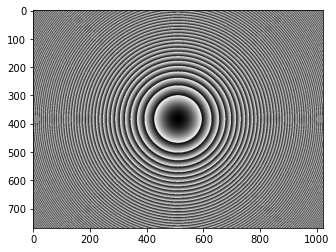

In [104]:
lens

array([[2.33349120e-11, 2.32765748e-11, 2.32183517e-11, ...,
        2.32183517e-11, 2.32765748e-11, 2.33349120e-11],
       [2.32911591e-11, 2.32328219e-11, 2.31745988e-11, ...,
        2.31745988e-11, 2.32328219e-11, 2.32911591e-11],
       [2.32475205e-11, 2.31891832e-11, 2.31309602e-11, ...,
        2.31309602e-11, 2.31891832e-11, 2.32475205e-11],
       ...,
       [2.32475205e-11, 2.31891832e-11, 2.31309602e-11, ...,
        2.31309602e-11, 2.31891832e-11, 2.32475205e-11],
       [2.32911591e-11, 2.32328219e-11, 2.31745988e-11, ...,
        2.31745988e-11, 2.32328219e-11, 2.32911591e-11],
       [2.33349120e-11, 2.32765748e-11, 2.32183517e-11, ...,
        2.32183517e-11, 2.32765748e-11, 2.33349120e-11]])

Offset en x en pixeles: 0
Offset en y en pixeles: 0
Ingresar p del segundo haz: 0
Ingresar l del segundo haz: 2
superposicion activada
